# AutTextification Model + Feature Engineering

In [ ]:
# -- Install libraries
!pip install transformers
!pip install llvmlite --ignore-installed
!pip install pycaret --upgrade
!pip install shap --upgrade

In [3]:
# -- Libraries
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import recall_score, f1_score, accuracy_score
from   transformers            import BertModel, BertTokenizer, AutoModelForSequenceClassification
from   torch.utils.data        import DataLoader, Dataset
from   tqdm                    import tqdm
from   scipy                   import stats
from   pycaret.classification  import *
import pandas                  as pd
import torch.nn                as nn
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import pickle
import torch
import shap
import re

# -- Define hyperparameters
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE  = 32
LEARNING_RATE    = 5e-5
WEIGHT_DECAY     = 0.01
EPOCHS           = 15
EN_TRAIN_DATA    = '/content/drive/MyDrive/Personal/AuTextification/subtask_1/en'
ES_TRAIN_DATA    = '/content/drive/MyDrive/Personal/AuTextification/subtask_1/es'

In [5]:
train_df_en = pd.read_csv('/kaggle/input/autextification/train_en.tsv', sep='\t')
train_df_en['lang'] = 'en'

train_df_es = pd.read_csv('/kaggle/input/autextification/train_es.tsv', sep='\t')
train_df_es['lang'] = 'es'

train_df = pd.concat([train_df_en, train_df_es])
train_df.reset_index(drop=True, inplace=True)
train_df['label'] = train_df['label'].apply(lambda x: 1 if x == 'generated' else 0)
train_df, test_df = train_test_split(train_df[['text', 'label']], test_size=0.2, random_state=42)

In [6]:
autextification_df = pd.read_csv('/kaggle/input/autextification-fe/autextification_fe.csv', sep=';')
autextification_df['label'] = autextification_df['label'].apply(lambda x: 1 if x == 'generated' else 0)
autextification_df['fe_num_signs_dup'] = autextification_df['text'].apply(lambda x: 
    len(re.findall(r"([\?\!\¿\¡]{2,})", x)
))

In [7]:
train_df_fe = autextification_df.iloc[list(train_df.index), :]
train_df_fe.reset_index(drop=True, inplace=True)
test_df_fe  = autextification_df.iloc[list(test_df.index), :]
test_df_fe.reset_index(drop=True, inplace=True)

## Feature engineering with PyCaret

In [7]:
autextification_df.drop(['id', 'text', 'lang'], axis=1, inplace=True)

In [8]:
# -- AutoML:
# ---- Fix imbalance
pd.set_option('display.max_rows', None)
s = setup(data = autextification_df, target = 'label', numeric_features=list(autextification_df.columns)[1:],
          feature_selection_method='classic', categorical_features = [], session_id=1234, feature_selection=True, 
          n_features_to_select=0.5, fix_imbalance=False)
best_model = compare_models(sort = 'F1', n_select=4, exclude=['lda', 'svm', 'et', 'nb', 'knn', 'ridge'])

,Description,Value
0,Session id,1234
1,Target,label
2,Target type,Binary
3,Original data shape,"(65907, 57)"
4,Transformed data shape,"(65907, 29)"
5,Transformed train set shape,"(46134, 29)"
6,Transformed test set shape,"(19773, 29)"
7,Numeric features,56
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7854,0.8724,0.7881,0.7851,0.7865,0.5707,0.5708,27.5410
rf,Random Forest Classifier,0.7752,0.8598,0.7904,0.7683,0.7792,0.5503,0.5506,12.1950
xgboost,Extreme Gradient Boosting,0.7723,0.8593,0.7745,0.7725,0.7735,0.5447,0.5447,11.1620
lightgbm,Light Gradient Boosting Machine,0.7702,0.8556,0.7801,0.7663,0.7731,0.5404,0.5405,1.4380
gbc,Gradient Boosting Classifier,0.7308,0.8131,0.7389,0.7285,0.7337,0.4615,0.4615,15.6090
ada,Ada Boost Classifier,0.6943,0.7691,0.6903,0.6974,0.6938,0.3886,0.3887,3.7990
dt,Decision Tree Classifier,0.6757,0.6757,0.6715,0.6788,0.6751,0.3514,0.3515,1.1930
dummy,Dummy Classifier,0.5018,0.5000,1.0000,0.5018,0.6683,0.0000,0.0000,0.2160
lr,Logistic Regression,0.6312,0.6945,0.6226,0.6352,0.6288,0.2624,0.2624,5.5550
qda,Quadratic Discriminant Analysis,0.6285,0.7275,0.3869,0.7528,0.5109,0.2583,0.2958,0.2840


Processing:   0%|          | 0/48 [00:00<?, ?it/s]

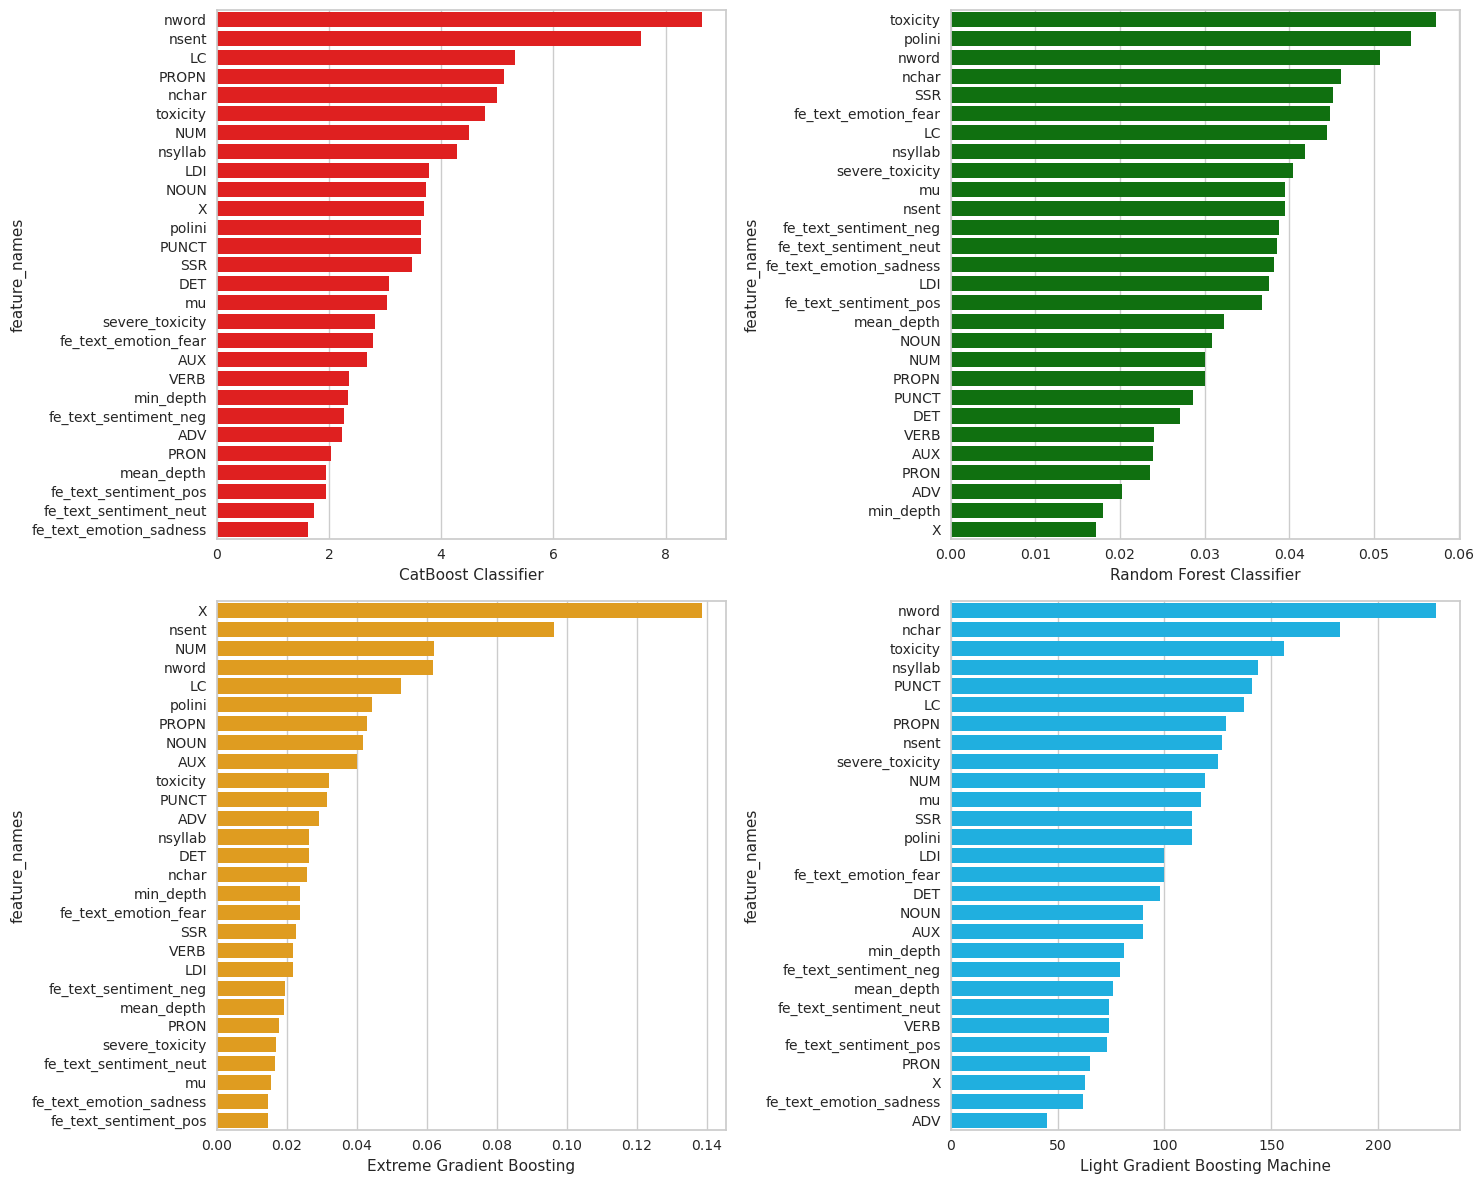

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
def plot_feature_importance(importance,names,model_type,i, j, col):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], ax=axs[i][j], color=col)
    axs[i][j].set_xlabel(model_type)

plot_feature_importance(best_model[0].feature_importances_, best_model[0].feature_names_,'CatBoost Classifier', 0, 0, col="red")
plot_feature_importance(best_model[1].feature_importances_, best_model[1].feature_names_in_,'Random Forest Classifier', 0, 1, col="green")
plot_feature_importance(best_model[2].feature_importances_, best_model[2].feature_names_in_,'Extreme Gradient Boosting', 1, 0, col="orange")
plot_feature_importance(best_model[3].feature_importances_, best_model[3].feature_name_,'Light Gradient Boosting Machine', 1, 1, col="deepskyblue")
plt.tight_layout()
plt.show()

__Normalizing Data__

In [25]:
# -- AutoML:
# ---- Fix imbalance
pd.set_option('display.max_rows', None)
s = setup(data = autextification_df, target = 'label', numeric_features=list(autextification_df.columns)[1:],
          feature_selection_method='classic', categorical_features = [], session_id=1234, feature_selection=True, 
          n_features_to_select=0.5, fix_imbalance=False, use_gpu=True, normalize=True)
best_model = compare_models(sort = 'F1', n_select=4, cross_validation=False, include=['mlp'], turbo=False)

,Description,Value
0,Session id,1234
1,Target,label
2,Target type,Binary
3,Original data shape,"(65907, 57)"
4,Transformed data shape,"(65907, 29)"
5,Transformed train set shape,"(46134, 29)"
6,Transformed test set shape,"(19773, 29)"
7,Numeric features,56
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
mlp,MLP Classifier,0.7712,0.8530,0.7787,0.7685,0.7736,0.5424,0.5424,80.4400


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

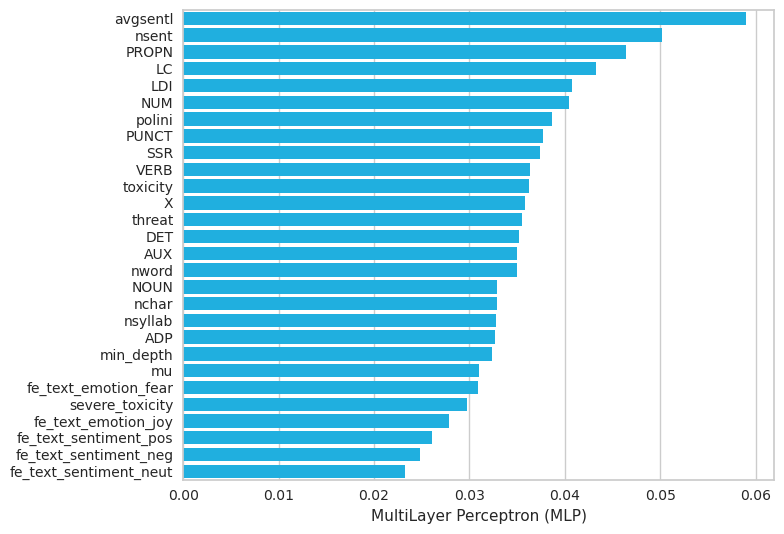

In [28]:
# -- Multilayer Perceptron (MLP)
importance = abs(best_model.coefs_[0]).sum(axis=1)
importance = importance / importance.sum()

feature_names = list(best_model.feature_names_in_)
importance_dict = dict(zip(feature_names, importance))

importance_sorted = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
feature_names_sorted = [x[0] for x in importance_sorted]
importance_sorted = [x[1] for x in importance_sorted]

sns.barplot(x=importance_sorted, y=feature_names_sorted, color="deepskyblue")
plt.xlabel('MultiLayer Perceptron (MLP)')
plt.tight_layout()
plt.show()

__Save best model: XGBoost__

In [10]:
with open('best_model_rf.pkl', 'wb') as file:
    clf = pickle.dump(best_model[1], file)

#### Predict with test data

In [9]:
autextification_fe_test    = pd.read_csv('/kaggle/input/autextification-fe-test/autextification_df_test.csv', sep=';')
autextification_fe_test_en = autextification_fe_test[autextification_fe_test['lang'] == 'en']
autextification_fe_test_es = autextification_fe_test[autextification_fe_test['lang'] == 'es']

In [13]:
with open('/kaggle/input/best-model-rf/best_model_rf.pkl', 'rb') as file:
    best_model = pickle.load(file)
features = list(best_model.feature_names_in_)

In [18]:
autextification_fe_test_en['label'] = best_model.predict(autextification_fe_test_en[features])
autextification_fe_test_en['label'] = autextification_fe_test_en['label'].apply(lambda x: 'generated' if x else 'human')
autextification_fe_test_en = autextification_fe_test_en[['id', 'label']]

autextification_fe_test_es['label'] = best_model.predict(autextification_fe_test_es[features])
autextification_fe_test_es['label'] = autextification_fe_test_es['label'].apply(lambda x: 'generated' if x else 'human')
autextification_fe_test_es = autextification_fe_test_es[['id', 'label']]

In [22]:
autextification_fe_test_es.to_csv('rf_run1_es.tsv', sep='\t', index=False)
autextification_fe_test_en.to_csv('rf_run1_en.tsv', sep='\t', index=False)

## Train new model using transformer + metadata

* External metadata:
    * nsent: Number of sentences
    * LC: Lexical Complexity Index
    * avgsentl: Average sentence length
    * polini: Polini's compressibility 
    * SSR index
    * LDI index

## Dataset

In [8]:
cols = ['nsent', 'LC', 'avgsentl', 'polini', 'SSR', 'LDI']
mean_std_dict = {col: [np.mean(train_df_fe[col]), np.std(train_df_fe[col])] for col in cols}

In [12]:
mean_std_dict

{'nsent': [3.9706211474632527, 2.192229443252219],
 'LC': [2.945973919848149, 1.518505637124846],
 'avgsentl': [14.664546469021746, 8.200782517498066],
 'polini': [47.65116818615951, 7.954951882075664],
 'SSR': [152.11535858921042, 41.1174801749095],
 'LDI': [5.050857083823797, 3.0329581176591907]}

In [30]:
class MyDataset(Dataset):
  def __init__(self, df, train=True):
    self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
    self.df = df    
    self.fe_nsent    = self.df.loc[:, 'nsent']
    self.fe_lc       = self.df.loc[:, 'LC']
    self.fe_avgsentl = self.df.loc[:, 'avgsentl']
    self.fe_polini   = self.df.loc[:, 'polini']
    self.fe_ssr      = self.df.loc[:, 'SSR']
    self.fe_ldi      = self.df.loc[:, 'LDI']
    self.train       = train
 
    self.fe_nsent_train    = torch.tensor(((self.fe_nsent - mean_std_dict['nsent'][0]) / mean_std_dict['nsent'][1]).values,dtype=torch.float32)
    self.fe_lc_train       = torch.tensor(((self.fe_lc - mean_std_dict['LC'][0]) / mean_std_dict['LC'][1]).values,dtype=torch.float32)
    self.fe_avgsentl_train = torch.tensor(((self.fe_avgsentl - mean_std_dict['avgsentl'][0]) / mean_std_dict['avgsentl'][1]).values,dtype=torch.float32)
    self.fe_polini         = torch.tensor(((self.fe_polini - mean_std_dict['polini'][0]) / mean_std_dict['polini'][1]).values,dtype=torch.float32)
    self.fe_ssr            = torch.tensor(((self.fe_ssr - mean_std_dict['SSR'][0]) / mean_std_dict['SSR'][1]).values,dtype=torch.float32)
    self.fe_ldi            = torch.tensor(((self.fe_ldi - mean_std_dict['LDI'][0]) / mean_std_dict['LDI'][1]).values,dtype=torch.float32)
    if self.train:
        self.labels            = torch.tensor((self.df['label']).values,dtype=torch.float32)
 
  def __len__(self):
    return self.df.shape[0]
   
  def __getitem__(self,idx):
    text_tokenized = self.bert_tokenizer(self.df.loc[idx, 'text'], truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    if self.train:
        return text_tokenized['input_ids'].squeeze().to(device), text_tokenized['attention_mask'].squeeze().to(device), \
               self.fe_nsent_train[idx].to(device).unsqueeze(-1), self.fe_lc_train[idx].to(device).unsqueeze(-1), \
               self.fe_avgsentl_train[idx].to(device).unsqueeze(-1), self.fe_polini[idx].to(device).unsqueeze(-1), \
               self.fe_ssr[idx].to(device).unsqueeze(-1), self.fe_ldi[idx].to(device).unsqueeze(-1), \
               self.labels[idx].squeeze().to(device)
    else:
        return text_tokenized['input_ids'].squeeze().to(device), text_tokenized['attention_mask'].squeeze().to(device), \
               self.fe_nsent_train[idx].to(device).unsqueeze(-1), self.fe_lc_train[idx].to(device).unsqueeze(-1), \
               self.fe_avgsentl_train[idx].to(device).unsqueeze(-1), self.fe_polini[idx].to(device).unsqueeze(-1), \
               self.fe_ssr[idx].to(device).unsqueeze(-1), self.fe_ldi[idx].to(device).unsqueeze(-1)

In [11]:
train_dataset = MyDataset(train_df_fe)
test_dataset  = MyDataset(test_df_fe)

## DataLoader

In [12]:
# Crear cargadores de datos
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

## Define Dataset class

In [34]:
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Cargar el modelo BERT pre-entrenado
        self.bert = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',output_hidden_states=True)
        self.bert.load_state_dict(torch.load("/kaggle/input/bert-uncased-best-model/bert_uncased_best_model.pth"))
        
        for p in self.bert.parameters():
            p.requires_grad = False
        
        # Definir una capa lineal para procesar las variables adicionales
        self.fc = nn.Linear(6, 32)
        
        # Definir una capa lineal para la salida del modelo
        self.fc_out = nn.Linear(768+32, 1)
        
        # Definir una capa de activación sigmoidea para obtener la probabilidad de clasificación
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, fe_nsent, fe_lc, fe_avgsentl, fe_polini, fe_ssr, fe_ldi):
        
        # Obtener la salida de BERT
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask).hidden_states[-1]
        pooled_output = torch.mean(output, dim=1)
        # pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output

        # Procesar las variables adicionales a través de una capa lineal
        fe_output = torch.cat([fe_nsent, fe_lc, fe_avgsentl, fe_polini, fe_ssr, fe_ldi], dim=-1)
        fe_output = self.fc(fe_output)
        
        # Concatenar las salidas de BERT y las variables adicionales
        concat_output = torch.cat([pooled_output, fe_output], dim=1)
        
        # Pasar la salida concatenada por una capa lineal y la activación sigmoidea
        logits = self.fc_out(concat_output)
        proba = self.sigmoid(logits).squeeze()
        
        return proba

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = BertBinaryClassifier().to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attention.self.query.bias True
bert.encoder.layer.0.attention.self.key.weight True
bert.encoder.layer.0.attention.self.key.bias True
bert.encoder.layer.0.attention.self.value.weight True
bert.encoder.layer.0.attention.self.value.bias True
bert.encoder.layer.0.attention.output.dense.weight True
bert.encoder.layer.0.attention.output.dense.bias True
bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.encoder.layer.0.intermediate.dense.weight True
bert.encoder.layer.0.intermediate.dense.bias True
bert.encoder.layer.0.output.dense.weight True
bert.encoder.layer.0.output.dense.bias True
bert.encoder.layer.0.output.LayerNorm.weight True


## Loss + Optimizer

In [15]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

## Train and eval

In [ ]:
# Iniciar el entrenamiento
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    print("Epoch {} of {}".format(epoch, EPOCHS))
    # Entrenar el modelo en el conjunto de entrenamiento
    print("Train step")
    model.train()
    for batch in tqdm(train_loader):
        # Obtener los datos de entrada y la etiqueta objetivo
        input_ids, attention_mask, fe_nsent, fe_lc, fe_avgsentl, fe_polini, fe_ssr, fe_ldi, labels = batch
        
        # Reiniciar los gradientes
        optimizer.zero_grad()
        
        # Obtener la salida del modelo y calcular la pérdida
        outputs = model(input_ids, attention_mask, fe_nsent, fe_lc, fe_avgsentl, fe_polini, fe_ssr, fe_ldi)
        loss = criterion(outputs, labels.float())
        
        # Realizar la retropropagación y la actualización de parámetros
        loss.backward()
        optimizer.step()
    
    # Evaluar el modelo en el conjunto de validación
    print("Eval step")
    model.eval()
    with torch.no_grad():
        val_loss = 0
        y_true, y_pred = [], []
        for batch in tqdm(val_loader):
            # Obtener los datos de entrada y la etiqueta objetivo
            input_ids, attention_mask, fe_nsent, fe_lc, fe_avgsentl, fe_polini, fe_ssr, fe_ldi, labels = batch
            
            # Obtener la salida del modelo y calcular la pérdida
            outputs = model(input_ids, attention_mask, fe_nsent, fe_lc, fe_avgsentl, fe_polini, fe_ssr, fe_ldi)
            val_loss += criterion(outputs, labels.float()).item()

            # Obtener las etiquetas predichas y las verdaderas
            pred_labels = torch.round(outputs)
            y_pred.extend(pred_labels.tolist())
            y_true.extend(labels.tolist())
        
        # Calcular la precisión, F1 y recall
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        
        # Save model if validation loss is lower than current best
        if (val_loss/len(val_loader)) < best_valid_loss:
            print("Val. loss has improved from {} to {}".format(best_valid_loss, val_loss/len(val_loader)))
            best_valid_loss = val_loss/len(val_loader)
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            print("Val. loss didn't improved")
        
        # Imprimir las estadísticas de entrenamiento y validación
        print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss/len(val_loader):.4f} - F1: {f1:.4f} - Accuracy: {accuracy:.4f} - Recall: {recall:.4f}')
    print("-" * 80)

Epoch 0 of 15
Train step


100%|██████████| 6591/6591 [29:59<00:00,  3.66it/s]


Eval step


100%|██████████| 412/412 [07:25<00:00,  1.08s/it]


Val. loss has improved from 0.1706607597032381 to 0.1706607597032381
Epoch 1/15 - Train Loss: 0.0110 - Val Loss: 0.1707 - F1: 0.9350 - Accuracy: 0.9307 - Recall: 0.9929
--------------------------------------------------------------------------------
Epoch 1 of 15
Train step


100%|██████████| 6591/6591 [29:57<00:00,  3.67it/s]


Eval step


100%|██████████| 412/412 [07:25<00:00,  1.08s/it]


Val. loss has improved from 0.16014216213771912 to 0.16014216213771912
Epoch 2/15 - Train Loss: 0.0151 - Val Loss: 0.1601 - F1: 0.9385 - Accuracy: 0.9347 - Recall: 0.9929
--------------------------------------------------------------------------------
Epoch 2 of 15
Train step


100%|██████████| 6591/6591 [29:57<00:00,  3.67it/s]


Eval step


100%|██████████| 412/412 [07:26<00:00,  1.08s/it]


Val. loss has improved from 0.15898320382659875 to 0.15898320382659875
Epoch 3/15 - Train Loss: 0.0100 - Val Loss: 0.1590 - F1: 0.9394 - Accuracy: 0.9357 - Recall: 0.9929
--------------------------------------------------------------------------------
Epoch 3 of 15
Train step


100%|██████████| 6591/6591 [29:57<00:00,  3.67it/s]


Eval step


100%|██████████| 412/412 [07:26<00:00,  1.08s/it]


Val. loss has improved from 0.15866992282070835 to 0.15866992282070835
Epoch 4/15 - Train Loss: 0.5067 - Val Loss: 0.1587 - F1: 0.9392 - Accuracy: 0.9354 - Recall: 0.9926
--------------------------------------------------------------------------------
Epoch 4 of 15
Train step


100%|██████████| 6591/6591 [29:57<00:00,  3.67it/s]


Eval step


100%|██████████| 412/412 [07:26<00:00,  1.08s/it]


Val. loss didn't improved
Epoch 5/15 - Train Loss: 0.0031 - Val Loss: 0.1680 - F1: 0.9360 - Accuracy: 0.9319 - Recall: 0.9932
--------------------------------------------------------------------------------
Epoch 5 of 15
Train step


100%|██████████| 6591/6591 [29:58<00:00,  3.67it/s]


Eval step


100%|██████████| 412/412 [07:25<00:00,  1.08s/it]


Val. loss didn't improved
Epoch 6/15 - Train Loss: 0.0551 - Val Loss: 0.1592 - F1: 0.9394 - Accuracy: 0.9357 - Recall: 0.9927
--------------------------------------------------------------------------------
Epoch 6 of 15
Train step


 83%|████████▎ | 5489/6591 [24:57<05:02,  3.64it/s]

#### Predict with test data

In [42]:
autextification_fe_test    = pd.read_csv('/kaggle/input/autextification-fe-test/autextification_df_test.csv', sep=';')

In [43]:
test_dataset = MyDataset(autextification_fe_test, train=False)
test_loader  = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = BertBinaryClassifier().to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [ ]:
# -- Load trained model (weights)
model.load_state_dict(torch.load('/kaggle/input/best-model-transformer-metadata/best_model.pt'))
model.eval()

In [45]:
# -- Test loop
with torch.no_grad():
    y_pred = []
    for batch in tqdm(test_loader):
        # Obtener los datos de entrada y la etiqueta objetivo
        input_ids, attention_mask, fe_nsent, fe_lc, fe_avgsentl, fe_polini, fe_ssr, fe_ldi = batch

        # Obtener la salida del modelo y calcular la pérdida
        outputs = model(input_ids, attention_mask, fe_nsent, fe_lc, fe_avgsentl, fe_polini, fe_ssr, fe_ldi)

        # Obtener las etiquetas predichas y las verdaderas
        pred_labels = torch.round(outputs)
        y_pred.extend(pred_labels.tolist())

100%|██████████| 1312/1312 [25:04<00:00,  1.15s/it]


In [51]:
# -- Save .tsv files
autextification_fe_test['label'] = y_pred
autextification_fe_test['label'] = autextification_fe_test['label'].apply(lambda x: "generated" if x else "human")
autextification_fe_test = autextification_fe_test[['id', 'label', 'lang']]
autextification_fe_test_en = autextification_fe_test[autextification_fe_test['lang'] == 'en'][['id', 'label']]
autextification_fe_test_es = autextification_fe_test[autextification_fe_test['lang'] == 'es'][['id', 'label']]

autextification_fe_test_es.to_csv('bert_uncased_metadata_run1_es.tsv', sep='\t', index=False)
autextification_fe_test_en.to_csv('bert_uncased_metadata_run1_en.tsv', sep='\t', index=False)